In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [3]:

df=pd.read_csv(r'/home/alihan/Desktop/Leren & Beslissen/General/Data(LLE)/Data/Houses/Houses1-19/House10-1m.csv')
  
#We need to set the Month column as index and convert it into datetime
df.set_index('timestamp',inplace=True)
df.index=pd.to_datetime(df.index)
df = df.resample('5T').mean()
df = df.loc['2019-04-01':'2019-04-08']
df.drop(df.columns[[0,2,3,4]], axis = 1, inplace = True)
df = df.iloc[2:]

df

<AxesSubplot:xlabel='timestamp'>

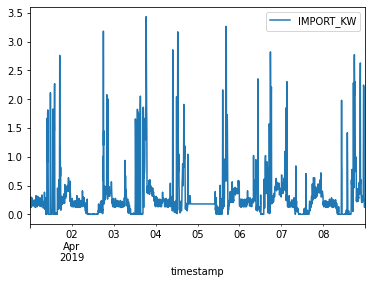

In [ ]:
df.plot()

In [ ]:
# load the dataset
dataframe = df
dataset = dataframe.values
dataset = dataset.astype('float32')

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
dataset

array([[0.05244756],
       [0.03846154],
       [0.04195804],
       ...,
       [0.05944056],
       [0.07342658],
       [0.06643357]], dtype=float32)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1542 760


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
1540/1540 - 2s - loss: 0.0128 - 2s/epoch - 1ms/step
Epoch 2/20
1540/1540 - 1s - loss: 0.0082 - 1s/epoch - 706us/step
Epoch 3/20
1540/1540 - 1s - loss: 0.0067 - 1s/epoch - 733us/step
Epoch 4/20
1540/1540 - 1s - loss: 0.0066 - 1s/epoch - 718us/step
Epoch 5/20
1540/1540 - 1s - loss: 0.0066 - 1s/epoch - 696us/step
Epoch 6/20
1540/1540 - 1s - loss: 0.0066 - 1s/epoch - 735us/step
Epoch 7/20
1540/1540 - 1s - loss: 0.0065 - 1s/epoch - 794us/step
Epoch 8/20
1540/1540 - 1s - loss: 0.0066 - 1s/epoch - 972us/step
Epoch 9/20
1540/1540 - 1s - loss: 0.0066 - 1s/epoch - 953us/step
Epoch 10/20
1540/1540 - 1s - loss: 0.0066 - 1s/epoch - 929us/step
Epoch 11/20
1540/1540 - 1s - loss: 0.0066 - 1s/epoch - 916us/step
Epoch 12/20
1540/1540 - 1s - loss: 0.0066 - 1s/epoch - 961us/step
Epoch 13/20
1540/1540 - 2s - loss: 0.0066 - 2s/epoch - 1ms/step
Epoch 14/20
1540/1540 - 1s - loss: 0.0066 - 1s/epoch - 962us/step
Epoch 15/20
1540/1540 - 2s - loss: 0.0065 - 2s/epoch - 1ms/step
Epoch 16/20
1540/1540 - 1

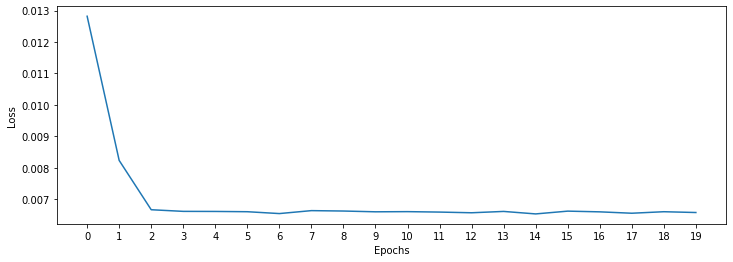

In [ ]:
losses = model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses)),losses);

In [14]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.28 RMSE
Test Score: 0.28 RMSE


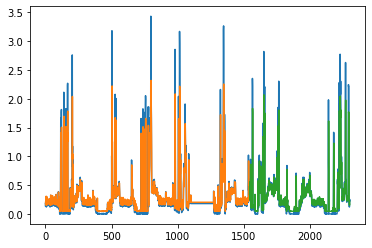

In [15]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()